Two-pane animation showing, on the left, positions of the Sun and selected planets in the night sky. The right panel shows line-of-sight from Earth to other planets, illustrating the cause of retrograde motion and annotating the beginning and ending dates of retrograde motion and the date of opposition with text. Retrograde motion is illustrated with a red line.

I wrote this script in Carnets app on my iPad ( https://apps.apple.com/us/app/carnets/id1450994949 ) and in Anaconda on my Mac ( https://www.anaconda.com ). There's a quirk in the interpreter (in both development environments) that causes the code to fail with error message `AttributeError: 'NoneType' object has no attribute 'remove_callback'`. I just ignore it and it runs the second time.

This script uses Skyfield api ( https://rhodesmill.org/skyfield/planets.html ).

Although I probably can't help you debug your program I would love to hear if you use this animation (or derivative) in your astronomy lessons or observations.

Good luck,

Stephen Shadle 🌌

swshadle@gmail.com

<IPython.core.display.Javascript object>


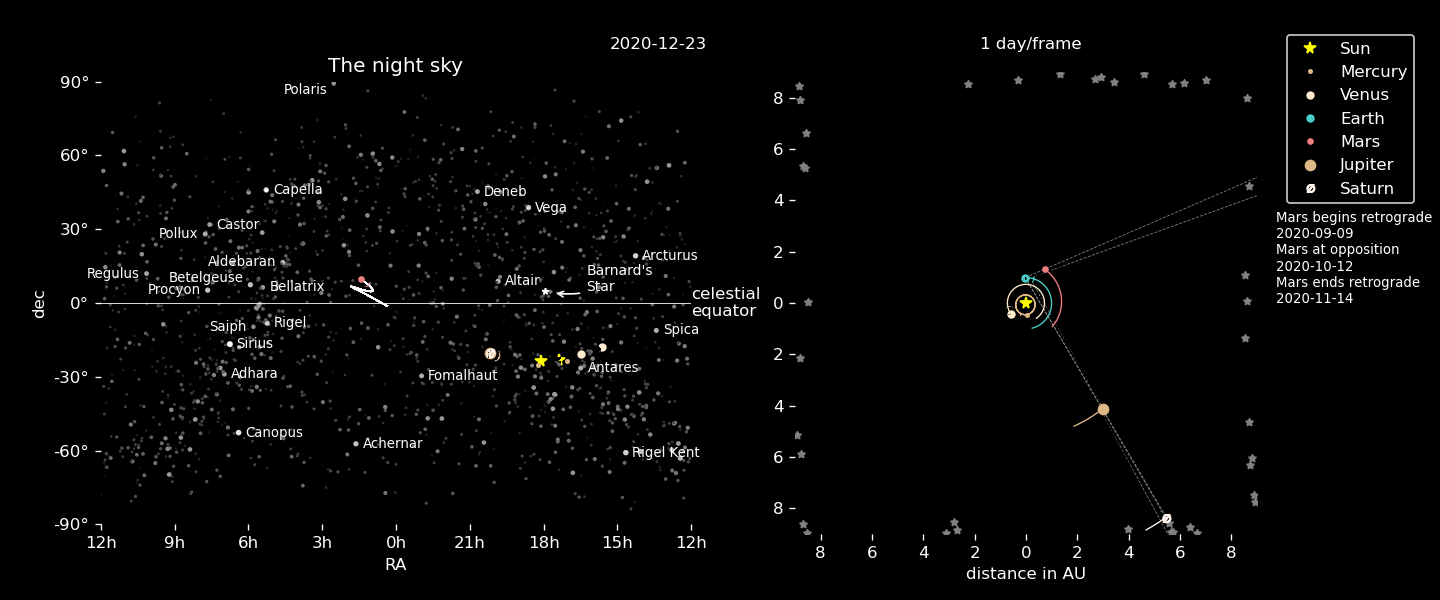

Displaying 26304 data points for Mars starting at 0.36 hours RA and -1.2 degrees
Barnard's star is at RA 18.0h dec 4.8° at distance 4e+05 AU
Before filtering, there are 118218 stars
After filtering for NaN (null data), there are 117955 stars
After filtering for magnitude (6.5 or brighter), there are 8870 stars
Sirius is at RA 6.8h (101.284°) dec -16.723° at distance 8.6 LY
Canopus is at RA 6.4h (95.988°) dec -52.696° at distance 312.7 LY
Arcturus is at RA 14.3h (213.909°) dec 19.171° at distance 36.7 LY
Rigel Kent is at RA 14.7h (219.859°) dec -60.831° at distance 4.4 LY
Vega is at RA 18.6h (279.236°) dec 38.785° at distance 25.3 LY
Capella is at RA 5.3h (79.173°) dec 45.996° at distance 42.2 LY
Rigel is at RA 5.2h (78.634°) dec -8.202° at distance 772.9 LY
Procyon is at RA 7.7h (114.821°) dec 5.219° at distance 11.4 LY
Betelgeuse is at RA 5.9h (88.793°) dec 7.407° at distance 427.5 LY
Achernar is at RA 1.6h (24.429°) dec -57.237° at distance 143.8 LY
Altair is at RA 19.8h (297.699°) d

/Users/Stavi/opt/anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


FFMpegWriter is available
20 seconds elapsed


In [3]:
# use "%pip install" to load skyfield api once then comment the line out:
###### %pip install skyfield
from skyfield.api import Star, load, Topos
from skyfield.data import hipparcos
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter, PillowWriter
import matplotlib.animation as animations
from datetime import datetime
%matplotlib notebook

KMperLY = 9460528405000 # km per ly

# with plt.xkcd(): # uncomment (and indent the rest of the script) if you want the figure to be in xkcd style (see https://matplotlib.org/xkcd/examples/showcase/xkcd.html)

# constructor class for making planets
class planets:
    def __init__(self, name, marker=None, color=None, markersize=None, trailmax=None):
        self.name       = name
        self.marker     = marker if marker is not None else 'o'
        self.color      = color if color is not None else 'k'
        self.markersize = markersize if markersize is not None else 1

# creating list
plist = []

# appending instances to list
plist.append(planets(name='Sun',     color='yellow',          markersize=7, marker='*'))
plist.append(planets(name='Mercury', color='burlywood',       markersize=2))
plist.append(planets(name='Venus',   color='blanchedalmond',  markersize=4))
plist.append(planets(name='Earth',   color='mediumturquoise', markersize=4))
plist.append(planets(name='Mars',    color='lightcoral',      markersize=3))
plist.append(planets(name='Jupiter', color='burlywood',       markersize=6))
plist.append(planets(name='Saturn',  color='seashell',        markersize=5, marker=r'$\emptyset$'))
# plist.append(planets(name='Uranus',  color='paleturquoise',   markersize=5))
# plist.append(planets(name='Neptune', color='royalblue',       markersize=5))
# plist.append(planets(name='Pluto',   color='lightsalmon',     markersize=2))

# load skyfield ephemeris table from local directory (see https://rhodesmill.org/skyfield/planets.html)
eph = load('de421.bsp') # ephemeris table de421.bsp is only valid through 2053 Oct 9 (Julian date 2471184.5)
sun     = eph[plist[0].name]
mercury = eph[plist[1].name]
venus   = eph[plist[2].name]
earth   = eph[plist[3].name]
# moon    = eph[names[4]]
mars    = eph[plist[4].name]
jupiter = eph['Jupiter barycenter']
saturn  = eph['Saturn barycenter']
# uranus  = eph['Uranus barycenter']
# neptune = eph['Neptune barycenter']
# pluto   = eph['Pluto barycenter']

ts = load.timescale()

hours = (3*365+1)*24 # how long the animation should run (number of hours of data from ephemeris table)

interval = 24        # number of hours to skip forward for each frame of the animation
dpi = 120            # dots per inch for the image
hw = 9.0             # height and width of the solar system plot (ax2), in AU. 3.0 works for the inner planets through mars. 5 for Jupiter. 9 for Saturn.

numremoved = 0

start_time = datetime.now()
start_y = start_time.year  # 2020 (use numbers here to select a fixed start date rather than today's date)
start_m = start_time.month # 5
start_d = start_time.day   # 11
"""
Note about start_time. normally, setting start_time = datetime.now() is recommended. however, date of opposition
for each planet is calculated as occurring midway between the beginning and ending date of retrograde motion. if
today's date (datetime.now()) happens to fall after the beginning of retrograde motion, opposition will not be
included in the list of displayed events. in this case, it's better to manually set start_y, start_m, & start_d
back a month or two to include the start of retrograde motion and thus include a properly calculated opposition
date.

for example, jupiter's opposition date for 2020 is 2020-07-14. it enters retrograde on 2020-05-11. if the script
is run between 2020-05-11 and 2020-07-14 and start_time is set to datetime.now(), opposition will not be 
calculated and displayed so it's better to manually set start_y = 2020, start_m = 5, and start_d = 11 or earlier.
"""

t = ts.utc(start_y,start_m,start_d,range(hours))
while len(t)>1 and t[-1].tt>2471184.5:
    t=t[:-1]
    numremoved += 1

if numremoved:
    print(f'removed {numremoved} frames')
    hours -= numremoved
    t  = ts.utc(start_y,start_m,start_d,range(hours))

# assert an error if there is no remaining valid data
assert t[-1].tt<2471184.5, 'Dates are out of range'
assert hours>0, f'too few hours selected: {hours}'

sun_p     = eph[plist[0].name].at(t).ecliptic_position().au
mercury_p = eph[plist[1].name].at(t).ecliptic_position().au
venus_p   = eph[plist[2].name].at(t).ecliptic_position().au
earth_p   = eph[plist[3].name].at(t).ecliptic_position().au
# moon_p    = moon.at(t).ecliptic_position().au
mars_p    = eph[plist[4].name].at(t).ecliptic_position().au
jupiter_p = jupiter.at(t).ecliptic_position().au
saturn_p  = saturn.at(t).ecliptic_position().au
# uranus_p  = urаnus.at(t).ecliptic_position().au
# neptune_p = neptune.at(t).ecliptic_position().au
# pluto_p   = pluto.at(t).ecliptic_position().au

ps = [sun_p,
      mercury_p,
      venus_p,
      earth_p,
#       moon_p,
      mars_p,
      jupiter_p,
      saturn_p,
#       uranus_p,
#       neptune_p,
#       pluto_p,
     ]

maxsize = [-hw, hw]

fig = plt.figure(constrained_layout=False, figsize=(12, 5), dpi=dpi)

# create the figure on the left: the night sky
gs1 = fig.add_gridspec(nrows=1, ncols=1,
                       left=0.07,
                       right=0.48,
                       wspace=0.05)

ax1 = fig.add_subplot(gs1[0, 0], frameon=False, title='The night sky',
                      xlabel="RA",
                      ylabel="dec",
                      xticks=[24, 21, 18, 15, 12, 9, 6, 3, 0],
                      yticks=[-90,-60,-30,0,30,60,90])

ax1.set_aspect(1/10) # the aspect ratio needed to get the figure to display properly is a bit trial-and-error. obviously the left figure (ax1) isn't 10x as wide as it is high.
# ax1.set_aspect('equal')

# create the middle figure: the overhead view of the solar system
gs2 = fig.add_gridspec(nrows=1, ncols=1,
                       left=0.55,
                       right=0.875,
                       wspace=0.05)

ax2 = fig.add_subplot(gs2[0, 0], frameon=False)
ax2.set_aspect('equal')

# create the figure on the right: a space for listing events
gs3 = fig.add_gridspec(nrows=3, ncols=1,
                       left=0.875,
                       right=1,
                       hspace=0.05)

ax3 = fig.add_subplot(gs3[1:, :], frameon=False, xticks=[], yticks=[])
ax3.set_aspect(3/2)


# random background stars, from https://github.com/zingale/astro_animations/blob/master/solar_system_motion/retrograde/retrograde.py
import random
N = 10
xpos = []
ypos = []
starbox = [hw-0.5, hw]

for s in range(N):
    # right
    xpos.append(random.uniform( starbox[0], starbox[1]))
    ypos.append(random.uniform(-starbox[1], starbox[1]))

    # top
    xpos.append(random.uniform(-starbox[1], starbox[1]))
    ypos.append(random.uniform( starbox[0], starbox[1]))

    # left
    xpos.append(random.uniform(-starbox[0],-starbox[1]))
    ypos.append(random.uniform(-starbox[1], starbox[1]))

    # bottom
    xpos.append(random.uniform(-starbox[1], starbox[1]))
    ypos.append(random.uniform(-starbox[0],-starbox[1]))

ax2.scatter(xpos, ypos, s=20, marker=(5,1), color="grey")

dots   = []
trails = []

for i,p in enumerate(ps):
    x, y, z = p # z is ignored in 2D plots
    newdot, = ax2.plot([x[0]],
                       [y[0]],
#                        [z[0]],
                       marker=plist[i].marker,
                       ms=plist[i].markersize,
                       label=plist[i].name,
                       color=plist[i].color,
                      linestyle = 'None')
    dots.append(newdot)
    
    newtrail, = ax2.plot(x[:1],
                         y[:1],
#                          z[:1],
                         color=plist[i].color,
                         linewidth=0.01)
    trails.append(newtrail)

# mercury_x, mercury_y, mercury_z = ps[1]
# venus_x,   venus_y,   venus_z   = ps[2]
earth_x,   earth_y,   earth_z   = ps[3]
mars_x,    mars_y,    mars_z    = ps[4]
jupiter_x, jupiter_y, jupiter_z = ps[5]
saturn_x,  saturn_y,  saturn_z  = ps[6]

# get slopes for line-of-sight lines from earth through other planets
# mercury_slope  = (earth_y[0] - mercury_y[0])/(earth_x[0] - mercury_x[0])
# venus_slope    = (earth_y[0] -   venus_y[0])/(earth_x[0] -   venus_x[0])
mars_slope    = (earth_y[0] -    mars_y[0])/(earth_x[0] -    mars_x[0])
jupiter_slope = (earth_y[0] - jupiter_y[0])/(earth_x[0] - jupiter_x[0])
saturn_slope  = (earth_y[0] -  saturn_y[0])/(earth_x[0] -  saturn_x[0])

# endpoint of line-of-sight line should be to the right of the figure if the planet is to the right of earth & vice versa
# if earth_x[0]>mercury_x[0]:
#     mercury_xpt = -hw-0.5
# else:
#     mercury_xpt = hw+0.5
# mercury_ypt = earth_y[0] + mercury_slope*(mercury_xpt - earth_x[0])

# if earth_x[0]>venus_x[0]:
#     venus_xpt = -hw-0.5
# else:
#     venus_xpt = hw+0.5
# venus_ypt = earth_y[0] + venus_slope*(venus_xpt - earth_x[0])

if earth_x[0]>mars_x[0]:
    mars_xpt = -hw-0.5
else:
    mars_xpt = hw+0.5
mars_ypt = earth_y[0] + mars_slope*(mars_xpt - earth_x[0])

if earth_x[0]>jupiter_x[0]:
    jupiter_xpt = -hw-0.5
else:
    jupiter_xpt = hw+0.5
jupiter_ypt = earth_y[0] + jupiter_slope*(jupiter_xpt - earth_x[0])

if earth_x[0]>saturn_x[0]:
    saturn_xpt = -hw-0.5
else:
    saturn_xpt = hw+0.5
saturn_ypt = earth_y[0] + saturn_slope*(saturn_xpt - earth_x[0])

# mercuryeclat, mercury_eclon, mercuryecd = earth.at(t).observe(mercury).ecliptic_latlon()
# mercury_eclondel = mercury_eclon.radians[1:] - mercury_eclon.radians[:-1]
# mercury_prograde = mercury_eclondel >= 0.
# mercury_linecolor = ['grey' if mercury_prograde[i] else 'orangered' for i in range(len(mercury_prograde))]

# venus_eclat, venus_eclon, venus_ecd = earth.at(t).observe(venus).ecliptic_latlon()
# venus_eclondel = venus_eclon.radians[1:] - venus_eclon.radians[:-1]
# venus_prograde = venus_eclondel >= 0.
# venus_linecolor = ['grey' if venus_prograde[i] else 'orangered' for i in range(len(venus_prograde))]

mars_eclat, mars_eclon, mars_ecd = earth.at(t).observe(mars).ecliptic_latlon()
mars_eclondel = mars_eclon.radians[1:] - mars_eclon.radians[:-1]

jupiter_eclat, jupiter_eclon, jupiter_ecd = earth.at(t).observe(jupiter).ecliptic_latlon()
jupiter_eclondel = jupiter_eclon.radians[1:] - jupiter_eclon.radians[:-1]

saturn_eclat, saturn_eclon, saturn_ecd = earth.at(t).observe(saturn).ecliptic_latlon()
saturn_eclondel = saturn_eclon.radians[1:] - saturn_eclon.radians[:-1]

# combine into arrays with 2 columns to keep dates and motion in synch during data cleaning. column 0 is delta ecliptic longitude and column 1 is dates
mars_data2d    = np.stack((mars_eclondel,    t[:-1]), axis=1)
jupiter_data2d = np.stack((jupiter_eclondel, t[:-1]), axis=1)
saturn_data2d  = np.stack((saturn_eclondel,  t[:-1]), axis=1)

# data cleaning
def reject_outliers(data, m=2.):
    d = np.abs(data[:,0] - np.median(data[:,0]))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

filtered_mars_data2d    = reject_outliers(mars_data2d,200.)
filtered_jupiter_data2d = reject_outliers(jupiter_data2d,200.)
filtered_saturn_data2d  = reject_outliers(saturn_data2d,200.)

# identify where planet is in prograde (marked with a grey line) and retrograde (orange-red line)
mars_prograde    = filtered_mars_data2d[:,0]    >= 0.0
jupiter_prograde = filtered_jupiter_data2d[:,0] >= 0.0
saturn_prograde  = filtered_saturn_data2d[:,0]  >= 0.0

mars_motion_chg    = np.where(mars_prograde[:-1]    != mars_prograde[1:])[0]+1
jupiter_motion_chg = np.where(jupiter_prograde[:-1] != jupiter_prograde[1:])[0]+1
saturn_motion_chg  = np.where(saturn_prograde[:-1]  != saturn_prograde[1:])[0]+1

# make a structured array (events) to hold a list of notable events (begin/end retrograde & opposition) for the planets
dtype = [('Frame', np.int32), ('Date', (np.str_, 10)), ('Text', (np.str_, 25))]
events = np.array([], dtype=dtype)

# construct list of events for each planet
# mars:
opposition = 0 # the date of opposition is calculated as occuring midway through beginning and ending of retrograde motion
for i in mars_motion_chg:
    if not mars_prograde[i]:
        opposition = i
        events = np.concatenate((events, np.array([(i,'{:%Y-%m-%d}'.format(filtered_mars_data2d[i,1].utc_datetime()),"Mars begins retrograde")], dtype=dtype)), axis=0)
    else:
        if opposition != 0:
            opposition = (opposition + i) // 2 # integer floor division
            events = np.concatenate((events, np.array([(opposition,'{:%Y-%m-%d}'.format(filtered_mars_data2d[opposition,1].utc_datetime()),"Mars at opposition")], dtype=dtype)), axis=0)
        events = np.concatenate((events, np.array([(i,'{:%Y-%m-%d}'.format(filtered_mars_data2d[i,1].utc_datetime()),"Mars ends retrograde")], dtype=dtype)), axis=0)

# jupiter:
"""
Note that including events for jupiter and saturn beginning and ending retrograde makes for a long list since
these occur approximately every year (compared with every 2 years for mars). if you wish these events included,
uncomment them in the following code
"""
opposition = 0
for i in jupiter_motion_chg:
    if not jupiter_prograde[i]:
        opposition = i
#         events = np.concatenate((events, np.array([(i,'{:%Y-%m-%d}'.format(filtered_jupiter_data2d[i,1].utc_datetime()),"Jupiter begins retrograde")], dtype=dtype)), axis=0)
    else:
        if opposition != 0:
            opposition = (opposition + i) // 2 # integer floor division
            events = np.concatenate((events, np.array([(opposition,'{:%Y-%m-%d}'.format(filtered_jupiter_data2d[opposition,1].utc_datetime()),"Jupiter at opposition")], dtype=dtype)), axis=0)
#         events = np.concatenate((events, np.array([(i,'{:%Y-%m-%d}'.format(filtered_jupiter_data2d[i,1].utc_datetime()),"Jupiter ends retrograde")], dtype=dtype)), axis=0)

# saturn
opposition = 0
for i in saturn_motion_chg:
    if not saturn_prograde[i]:
        opposition = i
#         events = np.concatenate((events, np.array([(i,'{:%Y-%m-%d}'.format(filtered_saturn_data2d[i,1].utc_datetime()),"Saturn begins retrograde")], dtype=dtype)), axis=0)
    else:
        if opposition != 0:
            opposition = (opposition + i) // 2 # integer floor division
            events = np.concatenate((events, np.array([(opposition,'{:%Y-%m-%d}'.format(filtered_saturn_data2d[opposition,1].utc_datetime()),"Saturn at opposition")], dtype=dtype)), axis=0)
#         events = np.concatenate((events, np.array([(i,'{:%Y-%m-%d}'.format(filtered_saturn_data2d[i,1].utc_datetime()),"Saturn ends retrograde")], dtype=dtype)), axis=0)

# sort events by Frame number
events = np.sort(events, order='Frame')

# construct display_events from sorted events for all planets
display_events = np.array([], dtype=plt.Text)
text_x = 0.09
text_y = 1.03
text_y_delta = 0.12
fontsize=8

for i, frame in enumerate(events):
    display_events = np.concatenate((
                                     display_events,
                                     np.array([(ax3.text(text_x, text_y, 
                                                         '{}\n{}'.format(events['Text'][i], events['Date'][i]),
                                                         transform=ax3.transAxes,
                                                         fontsize=fontsize,
                                                         visible=False) # initially, events are hidden. they are revealed after the event has passed
                                                )
                                               ]
                                              )
                                    ))
    text_y -= text_y_delta

# store an array of colors (grey for prograde and orange-red for retrograde)
mars_linecolor    = ['grey' if mars_prograde[i]    else 'orangered' for i in range(len(mars_prograde))]
jupiter_linecolor = ['grey' if jupiter_prograde[i] else 'orangered' for i in range(len(jupiter_prograde))]
saturn_linecolor  = ['grey' if saturn_prograde[i]  else 'orangered' for i in range(len(saturn_prograde))]

# create the initial line-of-sight line through planets at the first (0th) data point. we'll do the rest in the animate function
# mercury_line,  = plt.plot([earth_x[0], mercury_xpt], [earth_y[0], mercury_ypt], "--", linewidth=0.5)
# mercury_line.set_color(mercury_linecolor[0])

# venus_line,  = plt.plot([earth_x[0], venus_xpt], [earth_y[0], venus_ypt], "--", linewidth=0.5)
# venus_line.set_color(venus_linecolor[0])

mars_line,    = ax2.plot([earth_x[0], mars_xpt],    [earth_y[0], mars_ypt],    "--", linewidth=0.5)
mars_line.set_color(mars_linecolor[0])

jupiter_line, = ax2.plot([earth_x[0], jupiter_xpt], [earth_y[0], jupiter_ypt], "--", linewidth=0.5)
jupiter_line.set_color(jupiter_linecolor[0])

saturn_line,  = ax2.plot([earth_x[0], saturn_xpt],  [earth_y[0], saturn_ypt],  "--", linewidth=0.5)
saturn_line.set_color(saturn_linecolor[0])

# get observational data as seen from Katy, Texas
katy = earth + Topos('29.785786 N', '95.824394 W')
apparent_sun  = katy.at(t).observe(sun)
apparent_merc = katy.at(t).observe(mercury)
apparent_vens = katy.at(t).observe(venus)#.apparent()
apparent_mars = katy.at(t).observe(mars)#.apparent()
apparent_jup  = katy.at(t).observe(jupiter)#.apparent()
apparent_sat  = katy.at(t).observe(saturn)#.apparent()

ra_sun,  dec_sun,  dist_sun  = apparent_sun.radec()
ra_merc, dec_merc, dist_merc = apparent_merc.radec()
ra_vens, dec_vens, dist_vens = apparent_vens.radec()
ra_mars, dec_mars, dist_mars = apparent_mars.radec()
ra_jup,  dec_jup,  dist_jup  = apparent_jup.radec()
ra_sat,  dec_sat,  dist_sat  = apparent_sat.radec()

print('Displaying {}'.format(len(ra_mars.hours)), 'data points for Mars starting at {:.2}'.format(ra_mars.hours[0]), 'hours RA and {:.2}'.format(dec_mars.degrees[0]), 'degrees', sep=' ')

with load.open(hipparcos.URL) as f:
    df = hipparcos.load_dataframe(f)

barnards_star = Star.from_dataframe(df.loc[87937])
astrometric_b = katy.at(t).observe(barnards_star)
ra_b, dec_b, distance_b = astrometric_b.radec()
print(f"Barnard's star is at RA {ra_b.hours[0]:.1f}h dec {dec_b.degrees[0]:.1f}° at distance {distance_b.au[0]:.1} AU")

print(f'Before filtering, there are {len(df)} stars')
df = df[df['ra_degrees'].notnull()]
print(f'After filtering for NaN (null data), there are {len(df)} stars')
df = df[df['magnitude'] <= 6.5]
print(f'After filtering for magnitude (6.5 or brighter), there are {len(df)} stars')

bright_stars = Star.from_dataframe(df)

astrometric_stars = katy.at(t[0]).observe(bright_stars)

ra_stars, dec_stars, distance_stars = astrometric_stars.radec()
ax1.scatter((ra_stars.hours-12)%24, dec_stars.degrees, 5 - df['magnitude'], 
             c=8 - df['magnitude'], 
             cmap='gray',
            )

w2d = [24, 0]
# h2d = [dec_mars.degrees.min()*1.05, dec_mars.degrees.max()*1.05] # includes height 5% above and below the path of mars to give a more "zoomed in" view
h2d = [-90, 90] # [-90, 90] shows entire height of the plot so no stars are cut off. path of mars and other planets is not as "zoomed in"
"""
Note there's a quirk in the plot display system. any changes to the height of the graph (h2d) might require a
tweak to ax1.set_aspect(###) in line 138
"""

horizon, = ax1.plot(w2d, [0, 0], "w-", linewidth=0.5)

texth = ax1.text(w2d[1], 0, 'celestial\nequator', verticalalignment='center')#, transform=ax1.transAxes)

ax1.plot((ra_mars.hours[0]-12)%24, dec_mars.degrees[0], 'w-', linewidth=0.5,)

sunDot,  = ax1.plot((ra_sun.hours[0]-12)%24,  dec_sun.degrees[0],  '*',                   color='yellow',         markersize=7, zorder=10)
mercDot, = ax1.plot((ra_merc.hours[0]-12)%24, dec_merc.degrees[0], 'o',                   color='burlywood',      markersize=2, zorder=10)
vensDot, = ax1.plot((ra_vens.hours[0]-12)%24, dec_vens.degrees[0], 'o',                   color='blanchedalmond', markersize=4, zorder=10)
marsDot, = ax1.plot((ra_mars.hours[0]-12)%24, dec_mars.degrees[0], 'o',                   color='lightcoral',     markersize=3, zorder=10)
jupDot,  = ax1.plot((ra_jup.hours[0]-12)%24,  dec_jup.degrees[0],  'o',                   color='burlywood',      markersize=6, zorder=10)
satDot,  = ax1.plot((ra_sat.hours[0]-12)%24,  dec_sat.degrees[0],  marker=r'$\emptyset$', color='seashell',       markersize=5, zorder=11)

bernardsDot, = ax1.plot((ra_b.hours[0]-12)%24, dec_b.degrees[0], 'w', zorder=8, markersize=4, marker=(5,2))

ax1.annotate("Barnard's\nStar",
            xy=((ra_b.hours[0]-12)%24, dec_b.degrees[0]), xycoords='data',
            xytext=(25, 0), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            patchB=bernardsDot,
                            connectionstyle="arc3,rad=-.2"),
            fontsize='small')

def annotate_star(hip, name, rotation=None, marker=None, va='center', ha='left'):
    assert hip in df.index, f'invalid Hiparcos star number: {hip}'
    star = Star.from_dataframe(df.loc[hip])
    astrometric = katy.at(t[0]).observe(star)
    ra, dec, distance = astrometric.radec()
    if dec.degrees < h2d[0] or dec.degrees > h2d[1]:
        print(f"OFF PLOT:{name} at RA {ra.hours:.1f}h ({ra._degrees:.3f}°) dec {dec.degrees:.3f}° at distance {distance.km/KMperLY:.1f} LY")
        return None
    if marker:
        ax1.plot((ra.hours-12)%24, dec.degrees, 'w', zorder=10, markersize=2, marker=marker)
    print(f"{name} is at RA {ra.hours:.1f}h ({ra._degrees:.3f}°) dec {dec.degrees:.3f}° at distance {distance.km/KMperLY:.1f} LY")
    return ax1.annotate(name,
                         rotation=rotation,
                         verticalalignment=va,
                         horizontalalignment=ha,
                         size=8,
            xy=((ra.hours-12)%24, dec.degrees), xycoords='data',
            xytext=(-4 if ha=='right' else 4, 0), textcoords='offset points',
            annotation_clip=True,
            )

# annotate the 23 or so brightest stars
siri_annot = annotate_star(32349, 'Sirius')
cano_annot = annotate_star(30438, 'Canopus')
arct_annot = annotate_star(69673, 'Arcturus')
rken_annot = annotate_star(71683, 'Rigel Kent')
vega_annot = annotate_star(91262, 'Vega')
cape_annot = annotate_star(24608, 'Capella', marker=(5,2))
rige_annot = annotate_star(24436, 'Rigel')#, va='bottom')
proc_annot = annotate_star(37279, 'Procyon', ha='right')
bete_annot = annotate_star(27989, 'Betelgeuse', ha='right', va='bottom')
ache_annot = annotate_star(7588,  'Achernar')
# hada_annot = annotate_star(68702, 'Hadar')
alta_annot = annotate_star(97649, 'Altair')
# acru_annot = annotate_star(60718, 'Acrux')
alde_annot = annotate_star(21421, 'Aldebaran', ha='right')#, marker=(5,2))
spic_annot = annotate_star(65474, 'Spica')
anta_annot = annotate_star(80763, 'Antares')
poll_annot = annotate_star(37826, 'Pollux', ha='right')
foma_annot = annotate_star(113368,'Fomalhaut')
dene_annot = annotate_star(102098,'Deneb')
# bcru_annot = annotate_star(62434, 'beta Cru')
# acen_annot = annotate_star(71681, 'alpha 2 Cen')
regu_annot = annotate_star(49669, 'Regulus', ha='right')
adha_annot = annotate_star(33579, 'Adhara')
cast_annot = annotate_star(36850, 'Castor')
# gcru_annot = annotate_star(61084, 'gamma Cru')
# shau_annot = annotate_star(85927, 'Shaula')
bell_annot = annotate_star(25336, 'Bellatrix')#, va='bottom')
pola_annot = annotate_star(11767, 'Polaris', ha='right', va='top')
saip_annot = annotate_star(27366, 'Saiph', ha='right')#, va='top')

ax1.set_xlim(w2d)
ax1.set_ylim(h2d)
ax2.set_xlim(maxsize)
ax2.set_ylim(maxsize)

ax2.set_ylabel(None, 
              labelpad = 14,
             )
ax2.set_xlabel('distance in AU',
#               labelpad = 14,
             ) # distance in AU

# set up animation of axis ticks and labels
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

ticks =  ax2.get_yticks()
ticks = ticks[1:] # compensates for an error in some versions of the 3d view system. might not be needed.

# set labels to integers with absolute values representing distance from sun in AU
ax2.set_xticklabels([int(abs(tick)) for tick in ticks])
ax2.set_yticklabels([int(abs(tick)) for tick in ticks])

yticks2d = ax1.get_yticks()
ax1.set_yticklabels([f"{tick}°" for tick in yticks2d])

xticks2d = ax1.get_xticks()
ax1.set_xticklabels([f"{(tick-12)%24}h" for tick in xticks2d])

handles, labels = ax2.get_legend_handles_labels()
plt.style.use(['dark_background'])
plt.rcParams['figure.facecolor'] = 'black'

ax2.legend(bbox_to_anchor=(1.34, 1.08), # bbox_to_anchor lets you set the legend outside the figure
               handles=handles,      # our updated list of handles
               loc='upper right',
               ncol=1,
               fontsize='medium',
               borderaxespad=0.0,
               shadow=True,
              )

if interval == 24:
    timeperframe = '1 day'
elif interval > 24:
    if interval%24==0:
        timeperframe = f'{interval//24} days'
    else:
        timeperframe = '{:^.1f} days'.format(interval/24)
elif interval == 1:
    timeperframe = '1 hr'
else:
    timeperframe = f'{interval} hrs'

# placement 0, 0 would be bottom-left. 1, 1 would be top-right.
text1 = ax2.text(-0.4, 1.05, '', transform=ax2.transAxes)
text2 = ax2.text(0.4, 1.05, f'{timeperframe}/frame', transform=ax2.transAxes)

# init function doesn't do anything currently. it's there if any setup is needed before starting the animation
def init():
    return dots, trails, text1, text2, display_events

def animate(hour):
    pctleft = (hours-hour-hours%interval)/hours
    pctzoom = 0.025+1.0*(1-np.sin((np.pi/2)*(pctleft)))
    text1.set_text('{:%Y-%m-%d}'.format(t[hour].utc_datetime()))
    ticks = ax2.get_yticks()

#   use decimal axis labels when zoomed in
    if pctzoom<0.0245:                  # :^.1f
        ax2.set_xticklabels([f'{abs(tick):.1f}' for tick in ticks])
        ax2.set_yticklabels([f'{abs(tick):.1f}' for tick in ticks])
    else:
        ax2.set_xticklabels([int(abs(tick)) for tick in ticks])
        ax2.set_yticklabels([int(abs(tick)) for tick in ticks])

# update planet postions and trails
    for i,p in enumerate(ps):
        x, y, z = p # z is ignored in 2D plots
        dots[i].remove()
        dots[i], = ax2.plot([x[hour]], [y[hour]],
                            marker=plist[i].marker,
                            ms=plist[i].markersize,
                            color=plist[i].color,
                            linestyle = 'None',
                        )

        trails[i].remove()
        trails[i], = ax2.plot(x[:hour], y[:hour],
                              color=plist[i].color,
                              linewidth= 0.8,
                              alpha = 1,
                        )

# draw a line connecting earth and another planet and extending a bit further out
#     mercury_slope = (earth_y[hour] - mercury_y[hour])/(earth_x[hour] - mercury_x[hour])
#     venus_slope   = (earth_y[hour] -   venus_y[hour])/(earth_x[hour] -   venus_x[hour])
    mars_slope    = (earth_y[hour] -    mars_y[hour])/(earth_x[hour] -    mars_x[hour])
    jupiter_slope = (earth_y[hour] - jupiter_y[hour])/(earth_x[hour] - jupiter_x[hour])
    saturn_slope  = (earth_y[hour] -  saturn_y[hour])/(earth_x[hour] -  saturn_x[hour])

#     if earth_x[hour]>mercury_x[hour]:
#         mercury_xpt = -hw-0.5
#     else:
#         mercury_xpt = hw+0.5
#     mercury_ypt = earth_y[hour] + mercury_slope*(mercury_xpt - earth_x[hour])
#     mercury_line.set_data((earth_x[hour], mercury_xpt), (earth_y[hour], mercury_ypt))
#     mercury_line.set_color(color=mercury_linecolor[hour])

#     if earth_x[hour]>venus_x[hour]:
#         venus_xpt = -hw-0.5
#     else:
#         venus_xpt = hw+0.5
#     venus_ypt = earth_y[hour] + venus_slope*(venus_xpt - earth_x[hour])
#     venus_line.set_data((earth_x[hour], venus_xpt), (earth_y[hour], venus_ypt))
#     venus_line.set_color(color=venus_linecolor[hour])

    if earth_x[hour]>mars_x[hour]:
        mars_xpt = -hw-0.5
    else:
        mars_xpt = hw+0.5
    mars_ypt = earth_y[hour] + mars_slope*(mars_xpt - earth_x[hour])
    mars_line.set_data((earth_x[hour], mars_xpt), (earth_y[hour], mars_ypt))
    mars_line.set_color(color=mars_linecolor[hour])

    if earth_x[hour]>jupiter_x[hour]:
        jupiter_xpt = -hw-0.5
    else:
        jupiter_xpt = hw+0.5
    jupiter_ypt = earth_y[hour] + jupiter_slope*(jupiter_xpt - earth_x[hour])
    jupiter_line.set_data((earth_x[hour], jupiter_xpt), (earth_y[hour], jupiter_ypt))
    jupiter_line.set_color(color=jupiter_linecolor[hour])

    if earth_x[hour]>saturn_x[hour]:
        saturn_xpt = -hw-0.5
    else:
        saturn_xpt = hw+.5
    saturn_ypt = earth_y[hour] + saturn_slope*(saturn_xpt - earth_x[hour])
    saturn_line.set_data((earth_x[hour], saturn_xpt), (earth_y[hour], saturn_ypt))
    saturn_line.set_color(color=saturn_linecolor[hour])

# update positions for sun and planets on plot on the left (ax1)
    sunDot.set_data((ra_sun.hours[hour]-12)%24, dec_sun.degrees[hour])
    mercDot.set_data((ra_merc.hours[hour]-12)%24, dec_merc.degrees[hour])
    vensDot.set_data((ra_vens.hours[hour]-12)%24, dec_vens.degrees[hour])
    marsDot.set_data((ra_mars.hours[hour]-12)%24, dec_mars.degrees[hour])
    jupDot.set_data((ra_jup.hours[hour]-12)%24, dec_jup.degrees[hour])
    satDot.set_data((ra_sat.hours[hour]-12)%24, dec_sat.degrees[hour])
    bernardsDot.set_data((ra_b.hours[hour]-12)%24, dec_b.degrees[hour])

    ax1.plot((ra_mars.hours[:hour]-12)%24, dec_mars.degrees[:hour],
                         color='w',
                         linewidth= 0.8,
                         alpha = 0.75,
                    )

# use set_visible to turn on events after the "hour" when they have occurred
    for i, n in enumerate(display_events):
        display_events[i].set_visible(events['Frame'][i]<hour)

    print(f'frame {hours-hour-hours%interval}/{hours} {pctleft:.0%} left') #ignored unless saving animation to movie (mp4 or gif)
    return dots, trails, text1, text2, display_events

progress_callback = lambda i, n: print(f'Saving frame {i+1} of {n}')
animation = FuncAnimation(fig, animate, 
                          frames=range(0,hours,interval), # run the animation for all days represented
                          interval=10, blit=False, repeat=False, 
                          repeat_delay=5,
                          init_func=init)

filename = f"mars retrograde inner planets.{dpi} dpi.{hours} pts.{timeperframe} per frame"

if FFMpegWriter.isAvailable():
    print('FFMpegWriter is available')
    writer = FFMpegWriter(fps=15, metadata=dict(artist='Stephen Shadle'), bitrate=1800)
    animation.save(filename=f'{filename}.mp4', writer=writer, progress_callback=progress_callback)
#   comment out the above animation.save line to run the animation without saving to a file
else:
    print('FFMpegWriter is not available')
    if PillowWriter.isAvailable():
        print('PillowWriter is available')
        Writer = animations.writers['pillow']
        writer = Writer(fps=60,
                        metadata=dict(artist='Stephen Shadle'),
                        bitrate=1800,
                       )
        animation.save(filename=f'{filename}.gif', writer=writer, dpi=dpi)
#       comment out the above animation.save line to run the animation without saving to a file
    else:
        print('PillowWriter is not available')

# elapsed time function
# PLACE THE FOLLOWING AT THE TOP
# from datetime import datetime
# from time import sleep
# start_time = datetime.now()

time_elapsed = datetime.now() - start_time

da, remainder  = divmod(time_elapsed.total_seconds(), 24*3600)
hrs, remainder = divmod(remainder, 3600)
mins, secs = divmod(remainder, 60)

if da:
    print(f'{int(da)} days {int(hrs)} hours {int(mins)} minutes {int(secs)} seconds elapsed')
elif hrs:
    print(f'{int(hrs)} hours {int(mins)} minutes {int(secs)} seconds elapsed')
elif mins:
    print(f'{int(mins)} minutes {int(secs)} seconds elapsed')
else:
    print(f'{int(secs)} seconds elapsed')